In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
# =========================
# Parâmetros do ajuste
# =========================
n = 9  # grau do polinômio (mesmo do .m)
entrada = Path("../REMOVER/remove_pontos.csv")  # nosso CSV (lat, lon, dg_res_calc_mgal)
saida_coef = Path("../REMOVER/Xa_coeficientes_polinomiais.txt")

In [3]:
# =========================
# Leitura dos dados
# =========================
dfp = pd.read_csv(entrada)

dfp

,lat,lon,H_zerotide_m,dg_helmert_mgal,dg_goco_mgal,dg_indirect_mgal,dg_residual_planilha_mgal,dg_res_calc_mgal,erro_mgal
0,-25.516756,-49.119866,901.0751,64.517168,41.4012,-0.002100,23.113868,23.118068,0.004200
1,-25.547078,-49.049065,919.3276,67.387901,36.1392,-0.002500,31.248701,31.251201,0.002500
2,-25.491400,-48.996752,961.0942,74.774243,31.8169,-0.002300,42.957343,42.959643,0.002300
3,-25.438241,-49.014173,935.6272,68.184230,32.9337,-0.003500,35.250530,35.254030,0.003500
4,-25.439573,-49.099058,882.9281,68.304470,39.3425,-0.002000,28.961970,28.963970,0.002000
...,...,...,...,...,...,...,...,...,...
30027,-22.780000,-48.610000,810.9000,1.014528,-13.2664,-0.000023,14.280928,14.280951,0.000023
30028,-24.240000,-48.590000,863.1000,38.928398,13.9987,-0.009798,24.929698,24.939496,0.009798
30029,-22.735000,-48.570000,686.1000,-11.366440,-12.8696,-0.009911,1.503160,1.513071,0.009911
30030,-23.931700,-48.533300,641.0000,-2.859735,-0.1051,-0.011099,-2.754635,-2.743535,0.011099


In [4]:
# Ajuste os nomes conforme seu CSV
lat = dfp["lat"].to_numpy()
lon = dfp["lon"].to_numpy()
AG_res = dfp["dg_res_calc_mgal"].to_numpy()

In [6]:
# =========================
# Covariância empírica (versão fiel ao MATLAB)
# - Distâncias em graus (lat/lon já em °)
# - smax = 4° como no script
# - ds ~ "densidade espacial média" (mesma fórmula)
# =========================
def spatial_covariance(lon, lat, values, smax_deg=4.0):
    """
    Replica a lógica do MATLAB:
      - Calcula ds a partir de uma fórmula de densidade
      - Faz pares (i,j), acumula produtos para bins de distância
      - Retorna a covariância média por bin e o vetor de distâncias
    Custo O(N^2): se N for muito grande, considere amostrar os pontos.
    """
    N = len(values)
    # d_s conforme o .m
    ds = np.sqrt((2 * np.pi * (smax_deg / 2) ** 2) / N)

    nbins = int(round(smax_deg / ds)) + 2
    covariance = np.zeros(nbins, dtype=float)
    counts = np.zeros(nbins, dtype=int)

    # Duplo loop (como no MATLAB). Para muitos pontos, isso pode ser pesado.
    for i in range(N):
        xi, yi, gi = lon[i], lat[i], values[i]
        # vetoriza o j loop (mais rápido que 2 for)
        dx = xi - lon
        dy = yi - lat
        r = np.sqrt(dx * dx + dy * dy)  # graus
        # ignora j==i
        r[i] = np.inf
        # máscara dentro do raio
        mask = r < smax_deg
        # índice do bin
        ir = np.round(r[mask] / ds).astype(int) + 1
        # acumula
        covariance.put(ir, covariance[ir] + gi * values[mask])
        counts.put(ir, counts[ir] + 1)

    # média por bin
    valid = counts != 0
    covariance[valid] = covariance[valid] / counts[valid]
    covdist = np.arange(nbins) * ds  # em graus
    return covariance[valid], covdist[valid]

covariance, covdist = spatial_covariance(lon, lat, AG_res, smax_deg=4.0)
s = covdist  # em graus (igual ao MATLAB)

R^2 = 0.954884


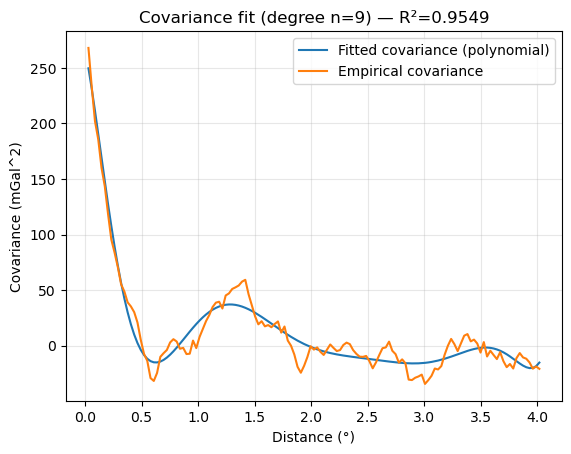

Coeficientes salvos em: /home/eroskerouak/physical-geodesy/pratica_geoide/REMOVER/Xa_coeficientes_polinomiais.txt


In [7]:
# =========================
# Ajuste polinomial por MMQ (sem inversa explícita)
# covariance = a0 + a1*s + ... + a_n*s^n
# =========================
# Monta Vandermonde com potências crescentes (1, s, s^2, ..., s^n)
A = np.vstack([s**k for k in range(n+1)]).T   # shape: (m amostras, n+1)
Lb = covariance

# Solução MMQ estável
Xa, *_ = np.linalg.lstsq(A, Lb, rcond=None)   # coeficientes a0..an

# Avaliação do polinômio ajustado
covariance_fit = A @ Xa

# R^2
ss_res = np.sum((Lb - covariance_fit) ** 2)
ss_tot = np.sum((Lb - Lb.mean()) ** 2)
R2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
print(f"R^2 = {R2:.6f}")

# =========================
# Plot comparando empírico vs ajustado
# =========================
plt.plot(s, covariance_fit, label="Fitted covariance (polynomial)", linewidth=1.5)
plt.plot(s, Lb, label="Empirical covariance", linewidth=1.5)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.xlabel("Distance (°)")
plt.ylabel("Covariance (mGal^2)")
plt.title(f"Covariance fit (degree n={n}) — R²={R2:.4f}")
plt.show()

# =========================
# Exporta coeficientes como no MATLAB
# (um coef por linha; se preferir CSV, troque o formato)
# =========================
np.savetxt(saida_coef, Xa[np.newaxis, :], fmt="%.10g")
print(f"Coeficientes salvos em: {saida_coef.resolve()}")
